In [1]:
%matplotlib inline


# UAV Tracking Demonstation


## Overview
Starting with GPS data from an instrumented UAV, we will generate range, bearing, and
elevation measurements (from a given radar position). We will use Stone Soup's simple
:class:`~.SingleTargetTracker` to perform the tracking. At this point we are primarly interested
in the necessary motion models that may be needed so the example is fairly simple, but
we want to be able to easily expand the simulation to handle more complex scenarios.

Items to note:

- Assumes a single target track, which simplifies track management.
- There is no clutter, and no missed detections. So 1:1 Data Association.
- Need an initiator and deleter for the tracker.
- GPS updates are 1 sec., we assume radar revisit is the same (little unrealistic)

We are assuming a ground based radar:

- Radar has course elevation resolution and fine bearing resolution.
- Use range standard deviation of 3.14 m as a replacement for range resolution.



## Setup: transition model, measurement model, updater and predictor



In [2]:
import numpy as np
from stonesoup.models.transition.linear import (
    ConstantVelocity,
    CombinedLinearGaussianTransitionModel
    )
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.models.measurement.nonlinear import (
    CartesianToElevationBearingRange
    )
from stonesoup.types.array import CovarianceMatrix


transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(1.0),
     ConstantVelocity(1.0),
     ConstantVelocity(1.0)])

# Model coords = elev, bearing, range. Angles in radians
meas_covar = np.diag([np.radians(np.sqrt(10.0))**2,
                      np.radians(0.6)**2,
                      3.14**2])

meas_covar_trk = CovarianceMatrix(1.0*meas_covar)
meas_model = CartesianToElevationBearingRange(
            ndim_state=6,
            mapping=np.array([0, 2, 4]),
            noise_covar=meas_covar_trk)
predictor = ExtendedKalmanPredictor(transition_model)
updater = ExtendedKalmanUpdater(measurement_model=meas_model)

## Setup CSV reader & feeder
Setup the reader and feeder to read the GPS data in
:download:`CSV file <../../demos/UAV_Rot.csv>`.
This part uses 2 Stone Soup detector type of classes:

- :class:`~.CSVGroundTruthReader` - reads our CSV file which contains: timestamp,
  latitude, longitude, altitude and other miscellaneous data.
- :class:`~.LLAtoENUConverter` - this is a feeder, but it converts our lat, long, 
  alt data into Cartesian (ENU).

The Cartesian(ENU) data will be converted to Range, Bearing, Altitude later on.
A more involved detector could:

- Add clutter.
- Handle $P_d$ behaviour. It could be based on radial velocity or other
  parameters.
- Handle radar revisit times.
- Add unknown number & multiple targets.




In [3]:
from stonesoup.reader.generic import CSVGroundTruthReader

ground_truth_reader = CSVGroundTruthReader(
    path='dataset/UAV_Rot.csv',
    state_vector_fields=['longitude', 'Vx m/s', 'latitude', 'Vy m/s', 'altitude (m)'],
    time_field='time',
    path_id_field='groupNb',
)

from stonesoup.feeder.geo import LLAtoENUConverter
sensor_location = [-30.948, 50.297311666, 0]  # Radar position [long, lat, alt]
ground_truth_reader = LLAtoENUConverter(ground_truth_reader, sensor_location, [0, 2, 4])

## Define Sensor, Platform and Detector
The sensor converts the Cartesian coordinates into range, bearing and elevation.
The sensor is then mounted onto a platform (stationary in this case)



In [4]:
from stonesoup.platform.base import FixedPlatform
from stonesoup.sensor.radar.radar import RadarElevationBearingRange
from stonesoup.simulator.platform import PlatformDetectionSimulator
from stonesoup.types.state import State

sensor = RadarElevationBearingRange(
    [0, 2, 4],
    meas_covar,
    6,
)
platform = FixedPlatform(
    State([0, 0, 0, 0, 0, 0]),  # Sensor at reference point, zero velocity
    [0, 2, 4],
    sensors=[sensor]
)

# Create the detector and initialize it.
detector = PlatformDetectionSimulator(ground_truth_reader, [platform])

## Setup Initiator class for the Tracker
This is just an heuristic initiation:
Assume most of the deviation is caused by the Bearing measurement error.
This is then converted into x, y components using the target bearing. For the
deviation in z,
we simply use $R\times\sigma_{elev}$ (ignore any bearing and range 
deviation components). Velocity covariances are simply based on the expected
velocity range of the targets.

**NOTE** - The Extended Kalman filter can be very sensitive to the state
initiation. Using the default :class:`~.SimpleMeasurementInitiator`, the estimates
tended to diverge over the course of the track when larger bearing measurement
covariances were used.



In [5]:
from stonesoup.types.state import GaussianState, State
from stonesoup.types.update import GaussianStateUpdate
from stonesoup.initiator.simple import SimpleMeasurementInitiator
from stonesoup.types.track import Track
from stonesoup.types.hypothesis import SingleHypothesis

class Initiator(SimpleMeasurementInitiator):
    def initiate(self, detections, time, **kwargs):
        MAX_DEV = 400.
        tracks = set()
        measurement_model = self.measurement_model
        for detection in detections:
            state_vector = measurement_model.inverse_function(
                            detection)
            model_covar = measurement_model.covar()

            el_az_range = np.sqrt(np.diag(model_covar)) #elev, az, range

            std_pos = detection.state_vector[2, 0]*el_az_range[1]
            stdx = np.abs(std_pos*np.sin(el_az_range[1]))
            stdy = np.abs(std_pos*np.cos(el_az_range[1]))
            stdz = np.abs(detection.state_vector[2, 0]*el_az_range[0])
            if stdx > MAX_DEV:
                print('Warning - X Deviation exceeds limit!!')
            if stdy > MAX_DEV:
                print('Warning - Y Deviation exceeds limit!!')  
            if stdz > MAX_DEV:
                print('Warning - Z Deviation exceeds limit!!')
            C0 = np.diag(np.array([stdx, 30.0, stdy, 30.0, stdz, 30.0])**2)

            tracks.add(Track([GaussianStateUpdate(
                state_vector,
                C0,
                SingleHypothesis(None, detection),
                timestamp=detection.timestamp)
            ]))
        return tracks


prior_state = GaussianState(
        np.array([[0], [0], [0], [0], [0], [0]]),
        np.diag([0, 30.0, 0, 30.0, 0, 30.0])**2)
initiator = Initiator(prior_state, meas_model)
#initiator = SimpleMeasurementInitiator(prior_state, meas_model)

## Setup Deleter for the Tracker
In the simple case of 1 target, we never want to delete the track. Because
this Deletor is so simple we haven't bothered using a subtype/inheritance
and instead make use of Python's duck typing. 



In [6]:
class MyDeleter:
    def delete_tracks(self, tracks):
        return set()

deleter = MyDeleter()

## Setup Hypothesiser and Associator
Since we know there is only one measurement per scan, we can just use the
:class:`~.NearestNeighbour` associator to achieve our desired result.



In [7]:
from stonesoup.measures import Euclidean
from stonesoup.dataassociator.neighbour import NearestNeighbour
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.tracker.simple import SingleTargetTracker
meas = Euclidean()
hypothesiser = DistanceHypothesiser(predictor, updater, meas)
associator = NearestNeighbour(hypothesiser)


tracker = SingleTargetTracker(initiator,
                              deleter,
                              detector,
                              associator,
                              updater)

## Run the Tracker
We extract the ground truth from the detector and then run the tracker.
While running the tracker we:

- Extract the measurement that is associated with it.
- Extract the position components of the estimated state vector.

This allows us to plot the measurements, ground truth, and state estimates.

**Note:** The meas_model.inverse_function() returns a state vector, which
for our CV model consists of [x, vx, y, vy, z, vz].



In [8]:
from matplotlib import pyplot as plt
est_X=[]
est_Y=[]
est_Z=[]
meas_X=[]
meas_Y=[]
meas_Z=[]
true_X = []
true_Y = []
true_Z = []

for time, tracks in tracker:
    for ground_truth in ground_truth_reader.groundtruth_paths:
        true_X.append(ground_truth.state_vector[0])
        true_Z.append(ground_truth.state_vector[1])
        true_Y.append(ground_truth.state_vector[2])

    # Because this is a single target tracker, I know there is only 1 track.
    for track in tracks:

        #Get the corresponding measurement
        detection = track.states[-1].hypothesis.measurement
        # Convert measurement into xy
        xyz = meas_model.inverse_function(detection)
        meas_X.append(xyz[0])
        meas_Z.append(xyz[1])
        meas_Y.append(xyz[2])

        vec = track.states[-1].state_vector
        est_X.append(vec[0])
        est_Z.append(vec[1])
        est_Y.append(vec[2])


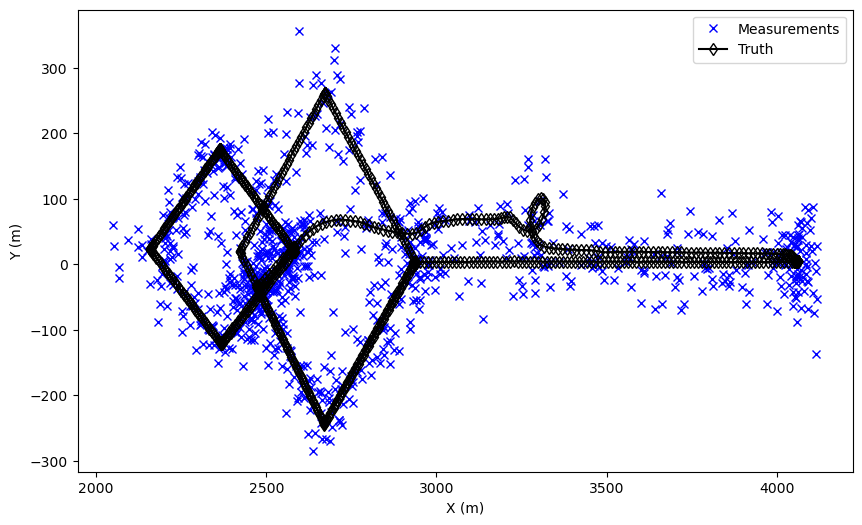

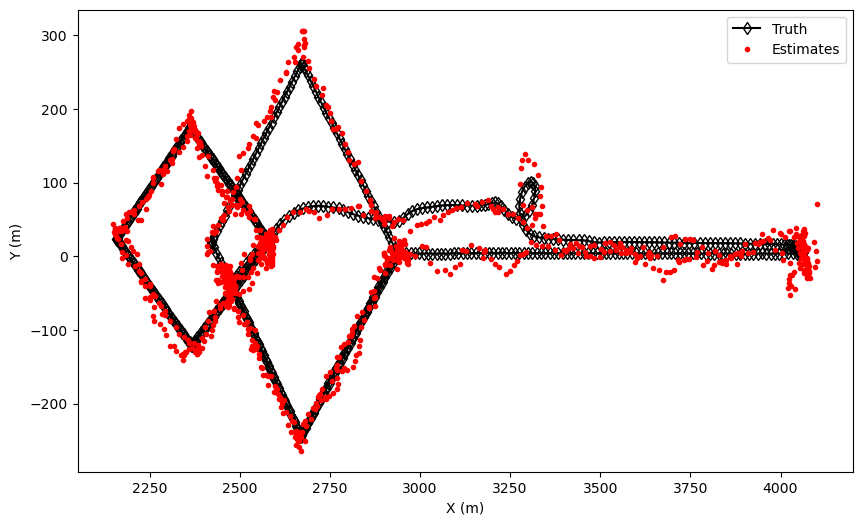

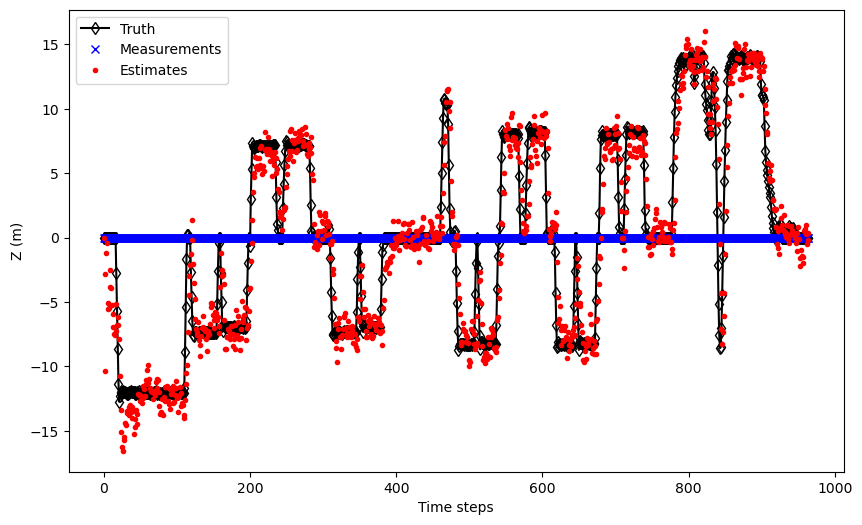

In [9]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
plt.plot(meas_X, meas_Y, 'xb', label='Measurements')
ax1.plot(true_X, true_Y, 'd-k', label='Truth', markerfacecolor='None')
ax1.legend()
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

fig = plt.figure(figsize=(10, 6))
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(true_X, true_Y, 'd-k', label='Truth', markerfacecolor='None')
ax2.plot(est_X, est_Y, 'r.', label='Estimates')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()

fig = plt.figure(figsize=(10, 6))
ax3 = fig.add_subplot(1, 1, 1)
ax3.plot(true_Z, 'd-k', label='Truth', markerfacecolor='None')
ax3.plot(meas_Z, 'xb', label='Measurements')
ax3.plot(est_Z, 'r.', label='Estimates')
ax3.set_ylabel('Z (m)')
ax3.set_xlabel('Time steps')
ax3.legend()

In [10]:
len(true_X)

965

## To Investigate
What happens when:

- Increase the bearing std deviation?
- Increase the model process noise?
- Move the radar?


